In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import math

In [ ]:
#Classical method for comparison
#Newton-Raphson
def newton_raphson_standard(f, df, x0, tol, max_iter = 100):
  """
  Finds a root of f(x) using Newton-Raphson method.
  Parameters:
  f: function - the function to find the root of
  df: function - the derivative of f(x)
  x0: float initial guess
  tol: float - Tolerance for stopping
  max_iter: int - mmaximum number of iterations

  returns:
  root, iterations, history
  """

  x = x0;
  iterations = 0

  for i in range(max_iter):
    fx = f(x)
    dfx = df(x)

    #Check if derivative is too small
    if abs(dfx) <1e-12:
      print("Newton-Raphson method fails: derivative is too small.")
      return None, iterations

    #Newton Raphson iteration
    x_new = x - fx/dfx
    iterations += 1

    #Check if root is close enough
    if abs(x_new - x) < tol or abs(f(x_new)) < tol:
      print(f"Converged in {i+1} iterations.")
      return x_new, iterations

    x = x_new
  print("Maximum iterations reached.")
  return x, iterations

In [ ]:
#Machine Learning Approach
#Nerual Network for best initial guess
def generate_training_data(n_samples = 1000):
  """
  Generates training data for neural network
  for quadratic equations ax^2 + bx + c = 0
  """
  np.random.seed(72)

  training_data = []

  for _ in range(n_samples):
    #Random quadratic
    a = np.random.uniform(0.5, 5)
    b = np.random.uniform(-10, 10)
    c = np.random.uniform(-10, 10)

    #Calculate the actual roots using quadratic formula
    discriminant = b**2 - 4*a*c

    if discriminant >= 0:
      root1 = (-b + np.sqrt(discriminant)) / (2*a)
      root2 = (-b - np.sqrt(discriminant)) / (2*a)

      #Use the root closest to 0
      if abs(root1) < abs(root2):
        best_root = root1
      else:
        best_root = root2


      #Store the coefficients and best guess
      training_data.append([a, b, c, best_root])

  training_data = np.array(training_data)
  X = training_data[:, :3] #Features a, b, and c
  y = training_data[:, 3] #Target good initial guess

  return X, y

In [ ]:
#Train the model
def train_initial_guess_predictor():
  """ Train the neural network to predict good initial guesses"""
  print("Training Neural Network")

  X, y = generate_training_data()
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 72)
  model = MLPRegressor(
      hidden_layer_sizes = (50, 30, 20),
      activation = 'relu',
      max_iter = 500,
      random_state = 72,
      early_stopping = True,
      verbose = False
  )

  model.fit(X_train, y_train)

  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)

  print("Training complete")
  print(f"Train R^2 Score: {train_score}")
  print(f"Test R^2 Score: {test_score}")

  return model
model = train_initial_guess_predictor()

Training Neural Network
Training complete
Train R^2 Score: 0.9236373803360981
Test R^2 Score: 0.8402534033561566


In [ ]:
#Machine Learning Enhanced Newton Method
def ml_enhanced_newton(a, b, c, tol = 1e-6, max_iter = 100):
  """Newton-Raphson with ML predicted initial guess"""
  #Define a function
  def f(x):
    return a*x**2 + b*x + c
  def df(x):
    return 2*a*x + b

  features = np.array([a, b, c]).reshape(1, -1) # Reshape to 2D array
  x0_predicted = model.predict(features)[0]

  root, iterations = newton_raphson_standard(f, df, x0_predicted, tol, max_iter)
  return root, iterations, x0_predicted

In [ ]:
#Comparsion Function for the 2 methods
def compare_classical_vs_ml(model, n_tests = 100):
  """Compare classical vs ML-enhanced Newton-Raphson"""
  np.random.seed(413)

  classical_iterations = []
  ml_iterations = []
  classical_successes = 0
  ml_successes = 0
  classical_failures = 0
  ml_failures = 0

  print("="*70)
  print("Comparing Classical vs ML-enhanced Newton-Raphson")
  print("="*70)
  tests_with_both_success = 0
  for i in range(n_tests):
    a = np.random.uniform(0.5, 5)
    b = np.random.uniform(-10, 10)
    c = np.random.uniform(-10, 10)

    discriminant = b**2-4*a*c
    if discriminant < 0:
      continue

    def f(x):
      return a*x**2 + b*x + c
    def df(x):
      return 2*a*x + b

    #Classical with random guess
    true_root = (-b + np.sqrt(discriminant))/(2*a)
    x0_random = true_root + np.random.uniform(-3, 3)
    root_classical, iterations_classical = newton_raphson_standard(f, df, x0_random, tol = 1e-6, max_iter = 100)

    #ML-enhanced with predicted
    root_ml, iterations_ml, x0_predicted = ml_enhanced_newton(a, b, c, tol = 1e-6, max_iter=100)

    #Track individual success rates
    classical_success = (root_classical is not None and iterations_classical<50)
    ml_success = (root_ml is not None and iterations_ml<50)

    if classical_success:
      classical_iterations.append(iterations_classical)
      classical_successes += 1
    else:
      classical_failures += 1

    if ml_success:
      ml_iterations.append(iterations_ml)
      ml_successes += 1
    else:
      ml_failures += 1

    #Track cases were both succeeded
    if classical_success and ml_success:
      tests_with_both_success += 1

  total_tests = classical_successes + classical_failures
  #Print Results
  print(f"Total tests: {total_tests}")
  print(f"Tests with both success: {tests_with_both_success}")

  print(f"\nClassical Newton-Raphson(random initial guess):")
  print(f"  Success rate: {classical_successes/total_tests*100:.2f}%")
  if classical_iterations:
    print(f"  Average iterations: {np.mean(classical_iterations):.2f}")
    print(f"  Std dev: {np.std(classical_iterations):.2f}")
    print(f"  Min/Max: {np.min(classical_iterations)}/{np.max(classical_iterations)}")
  print(f"\nML-Enhanced Newton-Raphson(random initial guess):")
  print(f"  Success rate: {ml_successes/total_tests*100:.2f}%")
  if ml_iterations:
    print(f"  Average iterations: {np.mean(ml_iterations):.2f}")
    print(f"  Std dev: {np.std(ml_iterations):.2f}")
    print(f"  Min/Max: {np.min(ml_iterations)}/{np.max(ml_iterations)}")

  print("Key Improvements")
  if classical_successes > 0 and ml_successes > classical_successes:
    improvement_rate = (ml_successes - classical_successes) / classical_successes * 100
    print(f"  ML-Enhanced Newton-Raphson is {improvement_rate:.2f}% more efficient.")
  elif ml_successes > classical_successes:
    print(f"  ML succeeded {ml_successes} times vs Classical {classical_successes}")

  if classical_iterations and ml_iterations:
    iter_improvement_rate = (np.mean(classical_iterations) - np.mean(ml_iterations)) / np.mean(classical_iterations)*100
    print(f"  ML-Enhanced Newton-Raphson uses {iter_improvement_rate:.2f}% less iterations on average.")

    if np.std(ml_iterations) < np.std(classical_iterations):
      consistency = (np.std(classical_iterations)-np.std(ml_iterations))/np.std(classical_iterations)*100
      print(f"  ML-Enhanced Newton-Raphson is {consistency:.2f}% more consistent.")

  print("="*70)
  return classical_iterations, ml_iterations

In [ ]:
#Plotting Function cause I dont wanna write it everytime :p
def plot_comparison(classical_iter, ml_iter):
  """Visualize the comparison"""
  fig, axes = plt.subplots(1, 2, figsize=(14,5))

  #Histogram
  axes[0].hist(classical_iter, bins = 20, alpha = 0.7, label = 'Classical', color = '#3498db')
  axes[0].hist(ml_iter, bins = 20, alpha = 0.7, label = 'ML-Enhanced', color = '#f2a2e8')
  axes[0].set_xlabel('Iterations', fontsize = 12)
  axes[0].set_ylabel('Frequency', fontsize = 12)
  axes[0].set_title('Distribution of Iterations', fontsize = 14)
  axes[0].legend()
  axes[0].grid(True, alpha = 0.3)

  #Box plot
  axes[1].boxplot([classical_iter, ml_iter], tick_labels=['Classical', 'ML-Enhanced'])
  axes[1].set_ylabel('Iterations', fontsize = 12)
  axes[1].set_title('Convergence Speed Comparison', fontsize = 14)
  axes[1].grid(True, alpha = 0.3)

  plt.tight_layout()
  plt.show()

Comparing Classical vs ML-enhanced Newton-Raphson
Converged in 4 iterations.
Converged in 3 iterations.
Converged in 6 iterations.
Converged in 3 iterations.
Converged in 4 iterations.
Converged in 2 iterations.
Converged in 4 iterations.
Converged in 2 iterations.
Converged in 4 iterations.
Converged in 3 iterations.
Converged in 4 iterations.
Converged in 3 iterations.
Converged in 7 iterations.
Converged in 2 iterations.
Converged in 5 iterations.
Converged in 2 iterations.
Converged in 5 iterations.
Converged in 1 iterations.
Converged in 3 iterations.
Converged in 2 iterations.
Converged in 6 iterations.
Converged in 2 iterations.
Converged in 4 iterations.
Converged in 2 iterations.
Converged in 5 iterations.
Converged in 3 iterations.
Converged in 3 iterations.
Converged in 3 iterations.
Converged in 3 iterations.
Converged in 2 iterations.
Converged in 5 iterations.
Converged in 2 iterations.
Converged in 4 iterations.
Converged in 3 iterations.
Converged in 6 iterations.
Conve

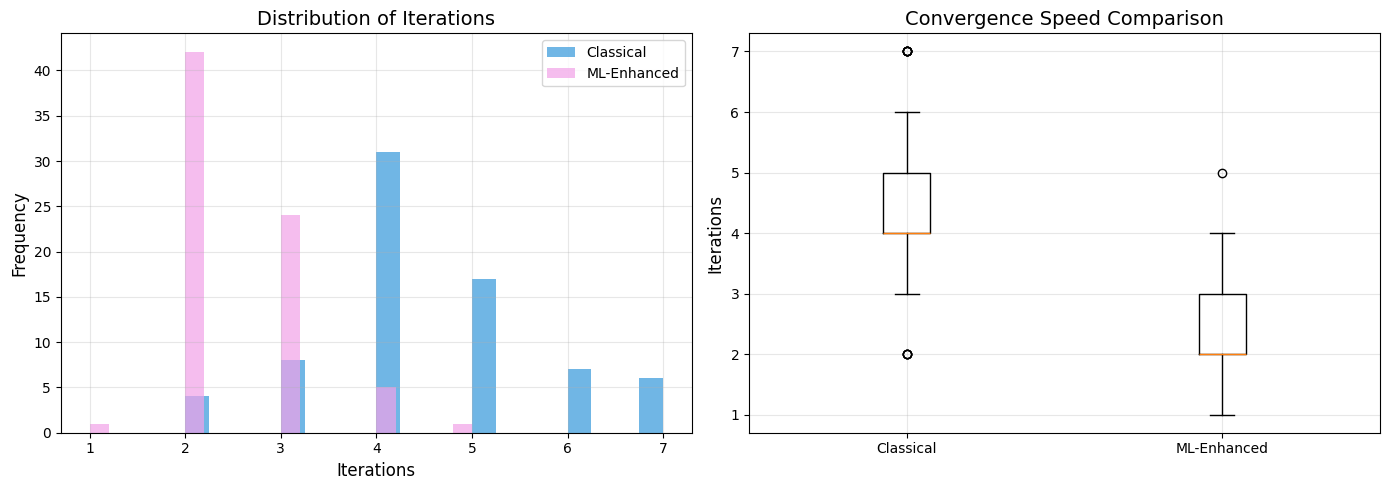

In [ ]:
#Run the comparison
classical_iters, ml_iters = compare_classical_vs_ml(model, n_tests = 100)

#Plot results
plot_comparison(classical_iters, ml_iters)